In [1]:
import os
from glob import glob
import cv2
import numpy as np
import h5py
import torch
from torch.utils.data import Dataset

class IrisPupilDataset(Dataset):
    def __init__(self, image_dir, mat_dir, img_size=(256, 256), transform=None):
        jpgs = sorted(glob(os.path.join(image_dir, '*.jpg')))
        mats = sorted(glob(os.path.join(mat_dir, '*.mat')))

        jpg_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in jpgs}
        mat_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in mats}

        jpg_bases = set(jpg_dict.keys())
        mat_bases = set(mat_dict.keys())

        common_basenames = sorted(jpg_bases & mat_bases)

        # Warnings
        if jpg_bases - mat_bases:
            print(f"⚠️ Images with no .mat: {sorted(jpg_bases - mat_bases)}")
        if mat_bases - jpg_bases:
            print(f"⚠️ .mat files with no image: {sorted(mat_bases - jpg_bases)}")

        self.samples = [(jpg_dict[b], mat_dict[b]) for b in common_basenames]
        self.img_size = img_size
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mat_path = self.samples[idx]

        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        H, W = img.shape[:2]

        # Load coordinates from .mat (in MATLAB (y,x) format)
        with h5py.File(mat_path, 'r') as f:
            cp = f['CC_PUPIL'][:].reshape(2)      # [y, x]
            rp = float(f['RADIO_PUPIL'][()])
            cs = f['CC_SCLERA'][:].reshape(2)     # [y, x]
            rs = float(f['RADIO_SCLERA'][()])

        # Flip to (x, y) for OpenCV
        cp_cv = (int(cp[1]), int(cp[0]))
        cs_cv = (int(cs[1]), int(cs[0]))

        # Create binary masks
        pupil_mask = np.zeros((H, W), dtype=np.uint8)
        cv2.circle(pupil_mask, center=cp_cv, radius=int(rp), color=1, thickness=-1)

        iris_full = np.zeros((H, W), dtype=np.uint8)
        cv2.circle(iris_full, center=cs_cv, radius=int(rs), color=1, thickness=-1)

        # Subtract pupil from iris
        iris_mask = iris_full.copy()
        iris_mask[pupil_mask > 0] = 0

        # Final combined mask
        mask = np.zeros((H, W), dtype=np.uint8)
        mask[iris_mask > 0] = 1
        mask[pupil_mask > 0] = 2

        # Transform or resize
        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img_resized, mask_resized = aug['image'], aug['mask']
        else:
            img_resized = cv2.resize(img, self.img_size, interpolation=cv2.INTER_LINEAR)
            mask_resized = cv2.resize(mask, self.img_size, interpolation=cv2.INTER_NEAREST)

        # To tensor
        img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).float() / 255.0
        mask_tensor = torch.from_numpy(mask_resized).long()

        return img_tensor, mask_tensor


⚠️ Images with no .mat: ['S1001L01', 'S1008L11', 'S1120L04', 'S1120L05', 'S1120L06', 'S1120L07', 'S1120R01', 'S1120R02', 'S1120R03', 'S1120R04', 'S1120R05', 'S1120R06', 'S1120R07', 'S1121L01', 'S1121L02', 'S1121L06', 'S1126L01', 'S1127L06', 'S1129L05', 'S1130L04', 'S1132R01', 'S1134R06', 'S1136R01', 'S1137L02', 'S1139L06', 'S1139R03', 'S1140L04', 'S1141R01', 'S1146L01', 'S1148R04', 'S1150L03', 'S1153L02', 'S1156L03', 'S1157R10', 'S1162L02', 'S1164R05', 'S1165R04', 'S1167L10', 'S1167R09', 'S1168R02', 'S1175L04', 'S1188R10', 'S1189L01', 'S1190L01', 'S1191L06', 'S1191L07', 'S1191L10', 'S1209L04', 'S1210L04', 'S1212L01', 'S1215L04', 'S1215L05', 'S1218R02', 'S1226R07', 'S1229L05', 'S1232L02', 'S1235R03', 'S1239R07']
⚠️ .mat files with no image: ['S1008R09', 'S1008R10', 'S1011L10', 'S1024R03', 'S1024R04', 'S1024R05', 'S1026R04', 'S1026R05', 'S1037R04', 'S1037R05', 'S1038L05', 'S1043R10', 'S1053L14', 'S1122R06', 'S1123R05', 'S1125L09', 'S1126L07', 'S1128L02', 'S1131R01', 'S1135R02', 'S1136L01

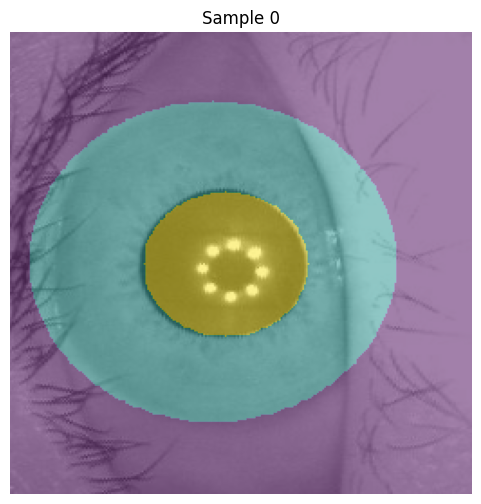

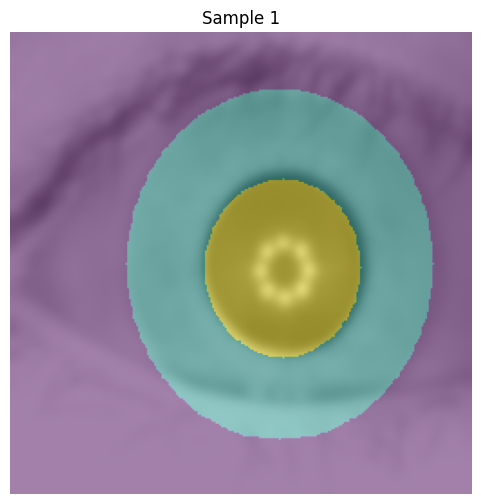

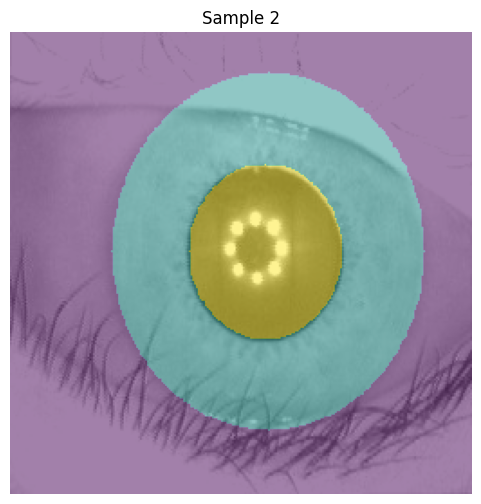

Train set size: 1096
Val set size: 274
Train sample shape: torch.Size([3, 256, 256]) torch.Size([256, 256])
Val sample shape: torch.Size([3, 256, 256]) torch.Size([256, 256])


In [2]:
import matplotlib.pyplot as plt
import albumentations as A
from torch.utils.data import random_split

train_transforms = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),                 # simulate lateral inversion
    A.RandomRotate90(p=0.5),                 # 90° rotations (safe for iris symmetry)
    A.RandomBrightnessContrast(p=0.3),       # simulate lighting variations
    A.GaussianBlur(p=0.2),                   # simulate poor focus / motion blur
    A.ElasticTransform(p=0.1, alpha=1),      # simulate eye deformation (e.g. Lamp)
])

val_transforms = A.Compose([
    A.Resize(256, 256)
])

# Step 5.2: Instantiate your dataset
dataset = IrisPupilDataset(
    image_dir='data/v3',
    mat_dir='data/v3_seg',
    img_size=(256, 256),
    transform=train_transforms
)

# Step 5.3: Visualize first 3 samples
for i in range(3):
    img_tensor, mask_tensor = dataset[i]
    img_np = img_tensor.permute(1, 2, 0).numpy()  # CHW to HWC
    mask_np = mask_tensor.numpy()

    plt.figure(figsize=(6, 6))
    plt.imshow(img_np)
    plt.imshow(mask_np, alpha=0.5)  # overlay
    plt.title(f"Sample {i}")
    plt.axis("off")
    plt.show()
    

# Step 6.2: Split sizes
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Step 6.3: Perform the split (reproducible)
train_dataset, val_dataset = random_split(
    dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Step 6.4: Override validation transform
val_dataset.dataset.transform = val_transforms

print("Train set size:", len(train_dataset))
print("Val set size:", len(val_dataset))

# Check one sample from each
img_t, mask_t = train_dataset[0]
print("Train sample shape:", img_t.shape, mask_t.shape)

img_v, mask_v = val_dataset[0]
print("Val sample shape:", img_v.shape, mask_v.shape)



In [3]:
from torch.utils.data import DataLoader

# Step 7.1: Define batch size
BATCH_SIZE = 16  # You can adjust depending on your GPU memory

# Step 7.2: Create loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,  # or 0 if you’re on Windows or see errors
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [4]:
# Step 7.3: Check one batch
batch = next(iter(train_loader))
imgs, masks = batch
print("🧪 Batch shapes:", imgs.shape, masks.shape)


🧪 Batch shapes: torch.Size([16, 3, 256, 256]) torch.Size([16, 256, 256])


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=3):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.middle = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.out_conv = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        m = self.middle(self.pool(e4))

        d4 = self.dec4(torch.cat([self.up4(m), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.out_conv(d1)


In [6]:
import torch.nn as nn
import torch.optim as optim

# Set weights to reduce background dominance
class_weights = torch.tensor([0.3, 1.0, 2.0]).to('cuda')  # background, iris, pupil

criterion = nn.CrossEntropyLoss(weight=class_weights)

# Initialize model
model = UNet(in_channels=3, num_classes=3).to('cuda')

# Optimizer (Adam works well for segmentation)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=8, shuffle=False, num_workers=2)



In [7]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for imgs, masks in loader:
        imgs, masks = imgs.to('cuda'), masks.to('cuda')

        optimizer.zero_grad()
        outputs = model(imgs)  # [B, 3, H, W]

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to('cuda'), masks.to('cuda')
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

    return total_loss / len(loader)



In [8]:
num_epochs = 12

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss   = validate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 1/12 — Train Loss: 0.2549, Val Loss: 0.1425
Epoch 2/12 — Train Loss: 0.1217, Val Loss: 0.1017
Epoch 3/12 — Train Loss: 0.0943, Val Loss: 0.0864
Epoch 4/12 — Train Loss: 0.0794, Val Loss: 0.0789
Epoch 5/12 — Train Loss: 0.0703, Val Loss: 0.0680
Epoch 6/12 — Train Loss: 0.0626, Val Loss: 0.0632
Epoch 7/12 — Train Loss: 0.0587, Val Loss: 0.0660
Epoch 8/12 — Train Loss: 0.0556, Val Loss: 0.0588
Epoch 9/12 — Train Loss: 0.0517, Val Loss: 0.0581
Epoch 10/12 — Train Loss: 0.0494, Val Loss: 0.0553
Epoch 11/12 — Train Loss: 0.0464, Val Loss: 0.0563
Epoch 12/12 — Train Loss: 0.0446, Val Loss: 0.0547


In [10]:
torch.save(model.state_dict(), "iris_pupil_unet.pth")


In [11]:
model = UNet(in_channels=3, num_classes=3)
model.load_state_dict(torch.load("iris_pupil_unet.pth"))
model = model.to('cuda').eval()


In [32]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import cv2
import numpy as np

def extract_circle_from_mask(binary_mask):
    ys, xs = np.where(binary_mask > 0)
    points = np.column_stack([xs, ys])  # flip to (x, y)
    if len(points) < 5:
        return None
    center, radius = cv2.minEnclosingCircle(points.astype(np.float32))
    return (int(center[0]), int(center[1])), int(radius)


def visualize_prediction_with_circles(model, dataset, idx=0, show_mask_overlay=True):
    model.eval()
    
    # Step 1: Get model input (resized) and original image
    img_tensor, _ = dataset[idx]
    img_tensor = img_tensor.unsqueeze(0).to('cuda')

    with torch.no_grad():
        logits = model(img_tensor)
        pred_mask = logits.argmax(dim=1)[0].cpu()

    resized_img_np = img_tensor[0].permute(1, 2, 0).cpu().numpy()
    pred_mask_np = pred_mask.numpy()

    # Step 2: Load full-res original image
    img_path, _ = dataset.dataset.samples[dataset.indices[idx]]
    full_res_img = cv2.imread(img_path)
    full_res_img = cv2.cvtColor(full_res_img, cv2.COLOR_BGR2RGB)
    full_res_vis = full_res_img.copy()

    H_full, W_full = full_res_img.shape[:2]
    H_resized, W_resized = resized_img_np.shape[:2]

    # Step 3: Resize predicted mask back to full-res for overlay and circle fitting
    full_mask = cv2.resize(pred_mask_np.astype(np.uint8), (W_full, H_full), interpolation=cv2.INTER_NEAREST)
    pupil_mask = (full_mask == 2).astype(np.uint8)
    iris_mask  = (full_mask == 1).astype(np.uint8)

    # Step 4: Draw mask contours (optional)
    if show_mask_overlay:
        contours_iris, _ = cv2.findContours(iris_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours_pupil, _ = cv2.findContours(pupil_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(full_res_vis, contours_iris, -1, (0, 255, 255), 2)   # cyan for iris
        cv2.drawContours(full_res_vis, contours_pupil, -1, (255, 255, 0), 2) # yellow for pupil

    # Step 5: Fit and draw circles
    pupil_circle = extract_circle_from_mask(pupil_mask)
    iris_circle  = extract_circle_from_mask(iris_mask)

    if pupil_circle:
        c, r = pupil_circle
        cv2.circle(full_res_vis, (int(c[0]), int(c[1])), int(r), (255, 255, 0), 2)
    if iris_circle:
        c, r = iris_circle
        cv2.circle(full_res_vis, (int(c[0]), int(c[1])), int(r), (0, 255, 255), 2)

    # Step 6: Plot everything
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(full_res_img)
    axes[0].set_title("Original Image")

    axes[1].imshow(pred_mask_np, cmap='jet', vmin=0, vmax=2)
    axes[1].set_title("Predicted Mask (Resized)")

    axes[2].imshow(full_res_vis)
    axes[2].set_title("Overlay: Mask + Fitted Circles")

    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    return pupil_circle, iris_circle


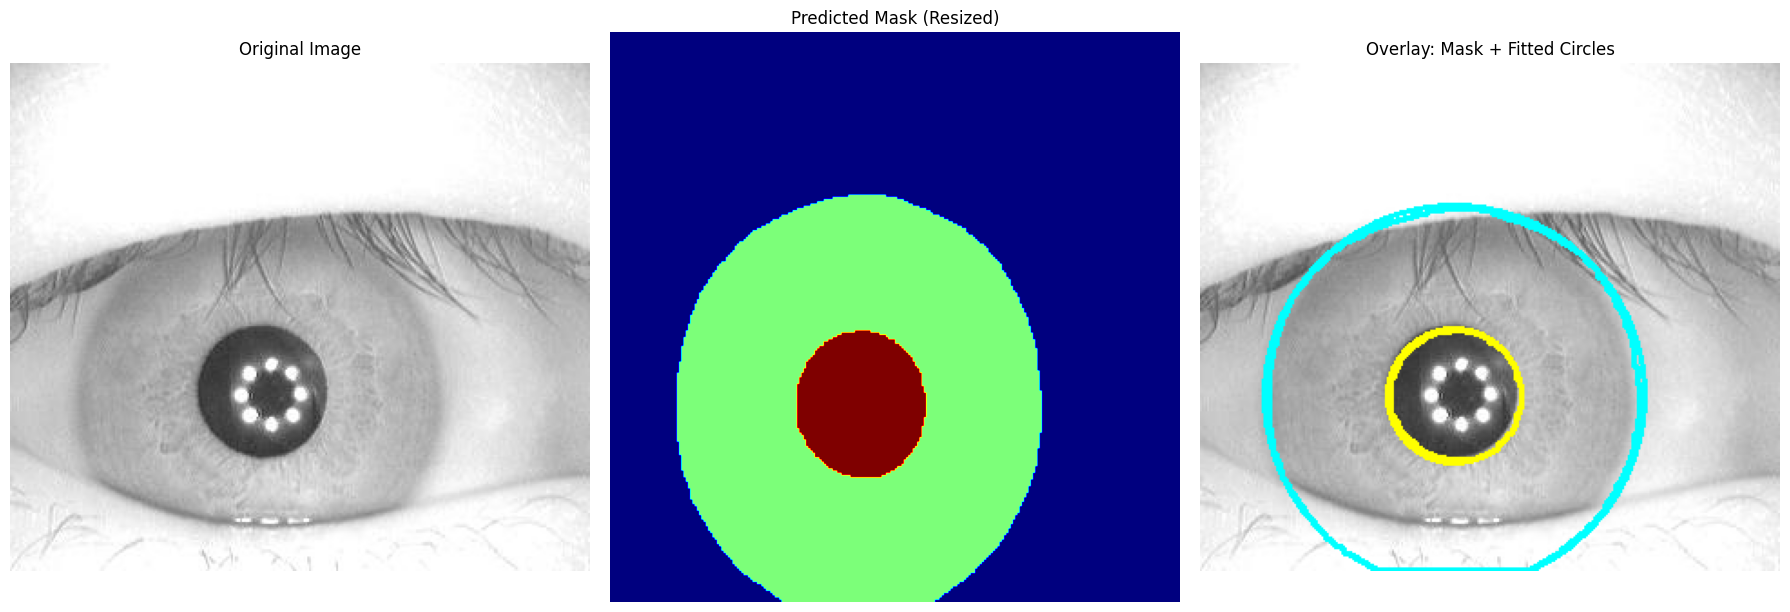

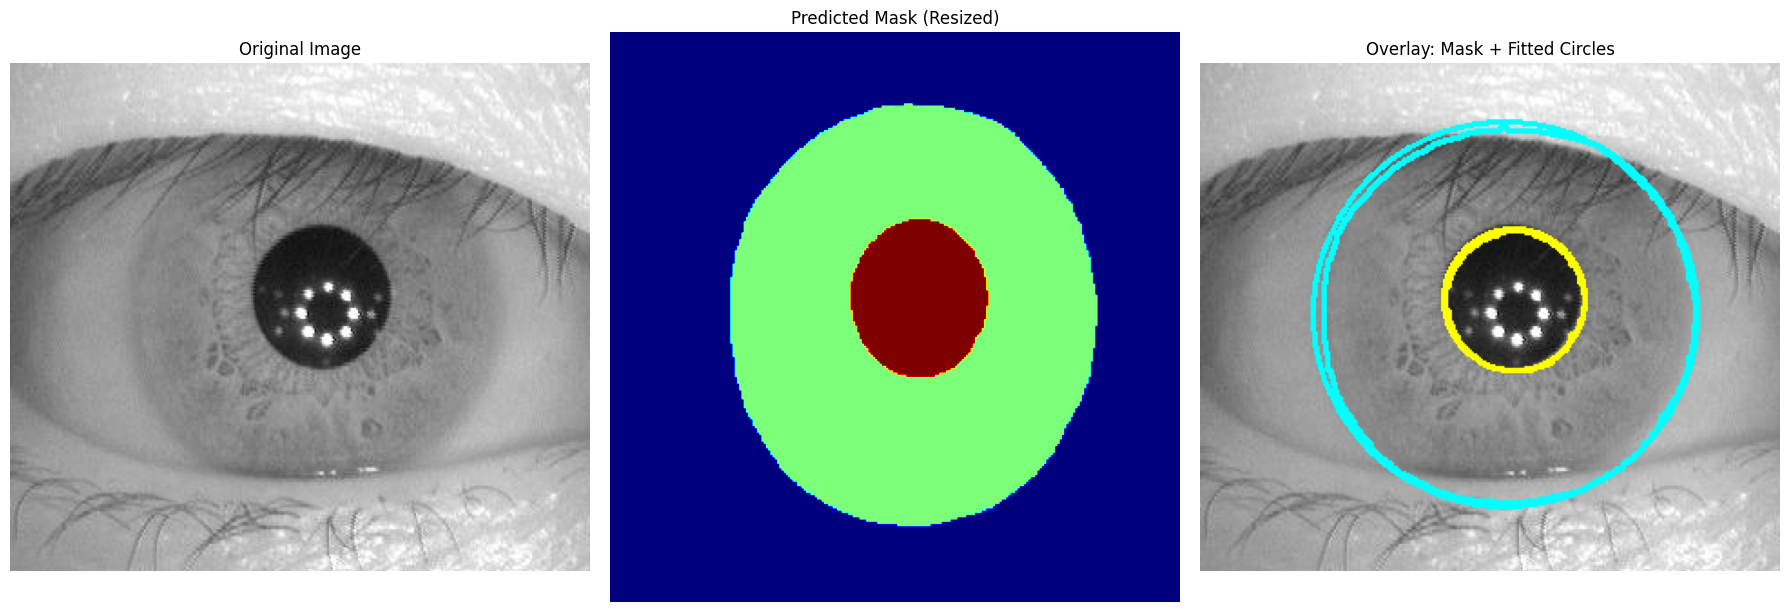

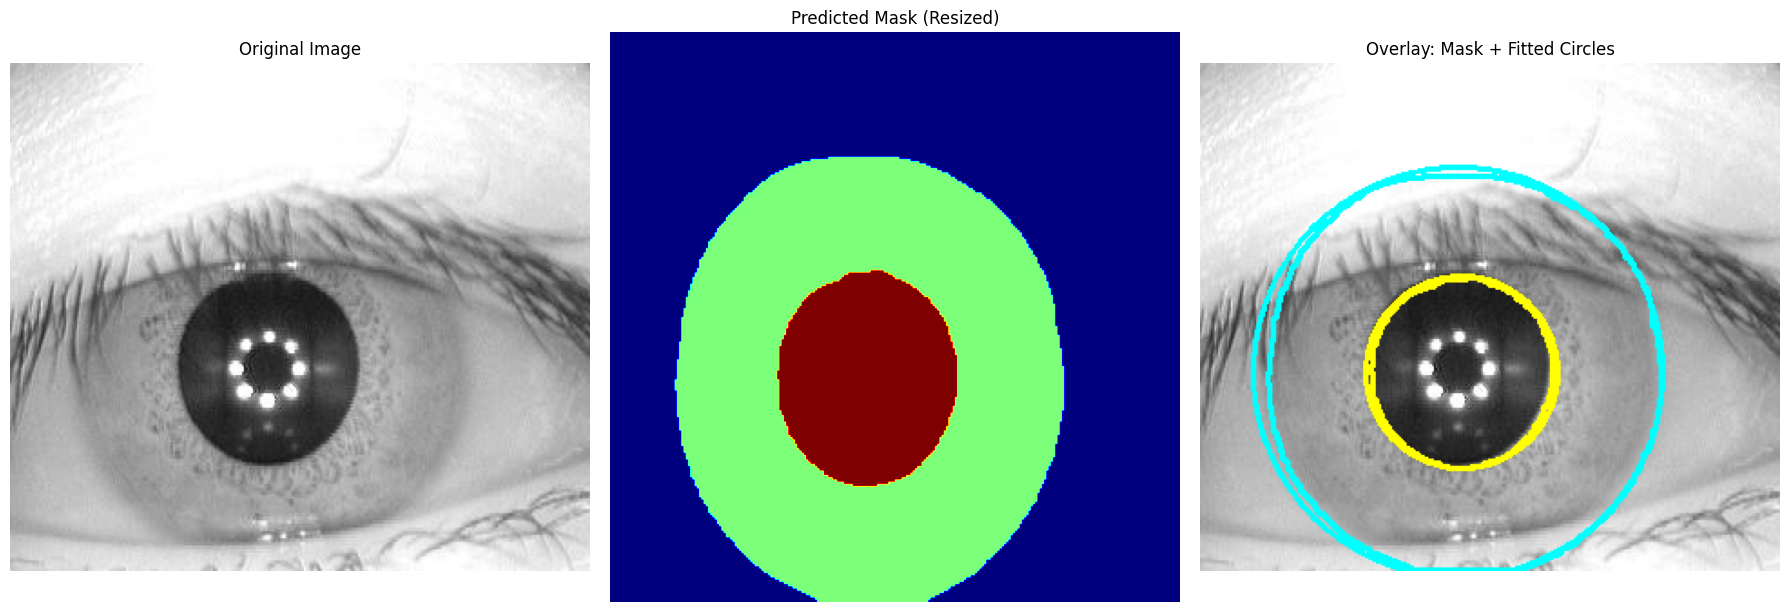

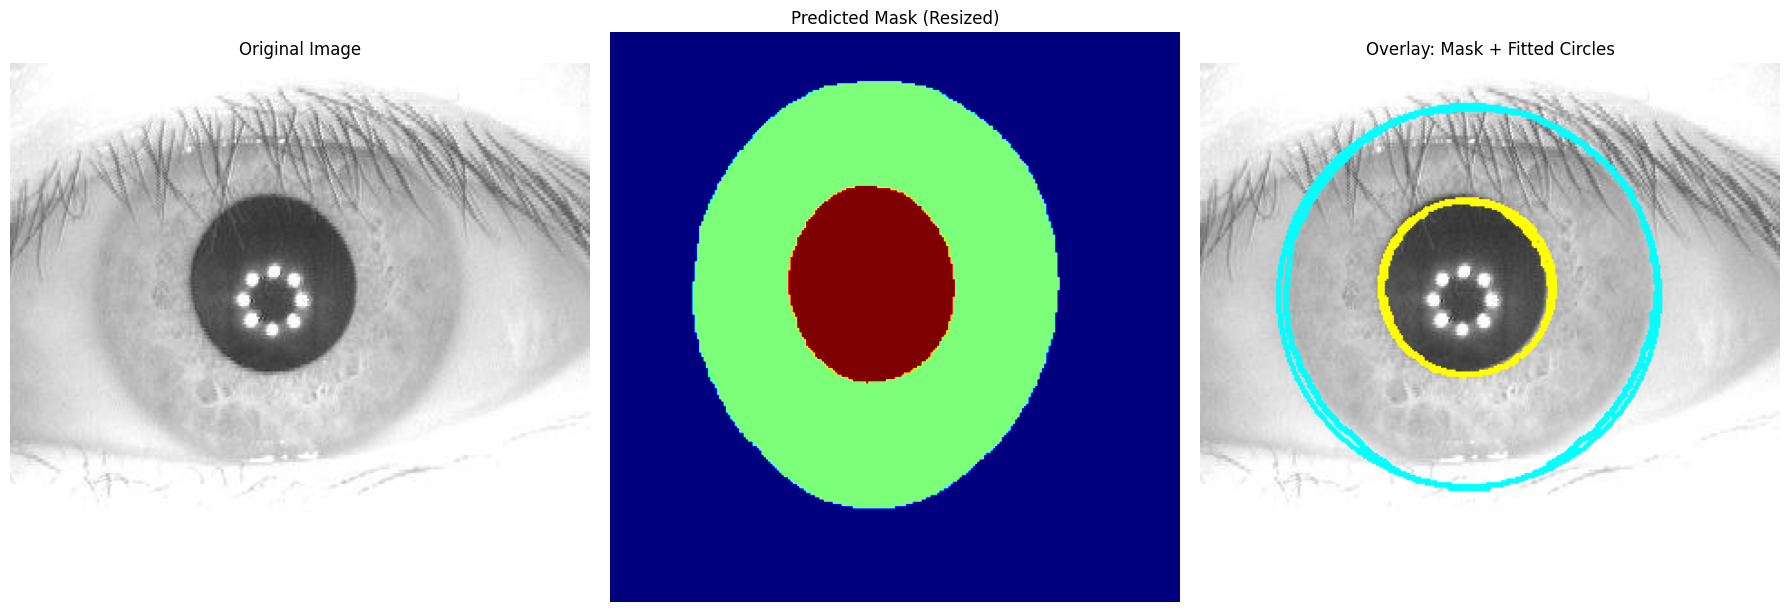

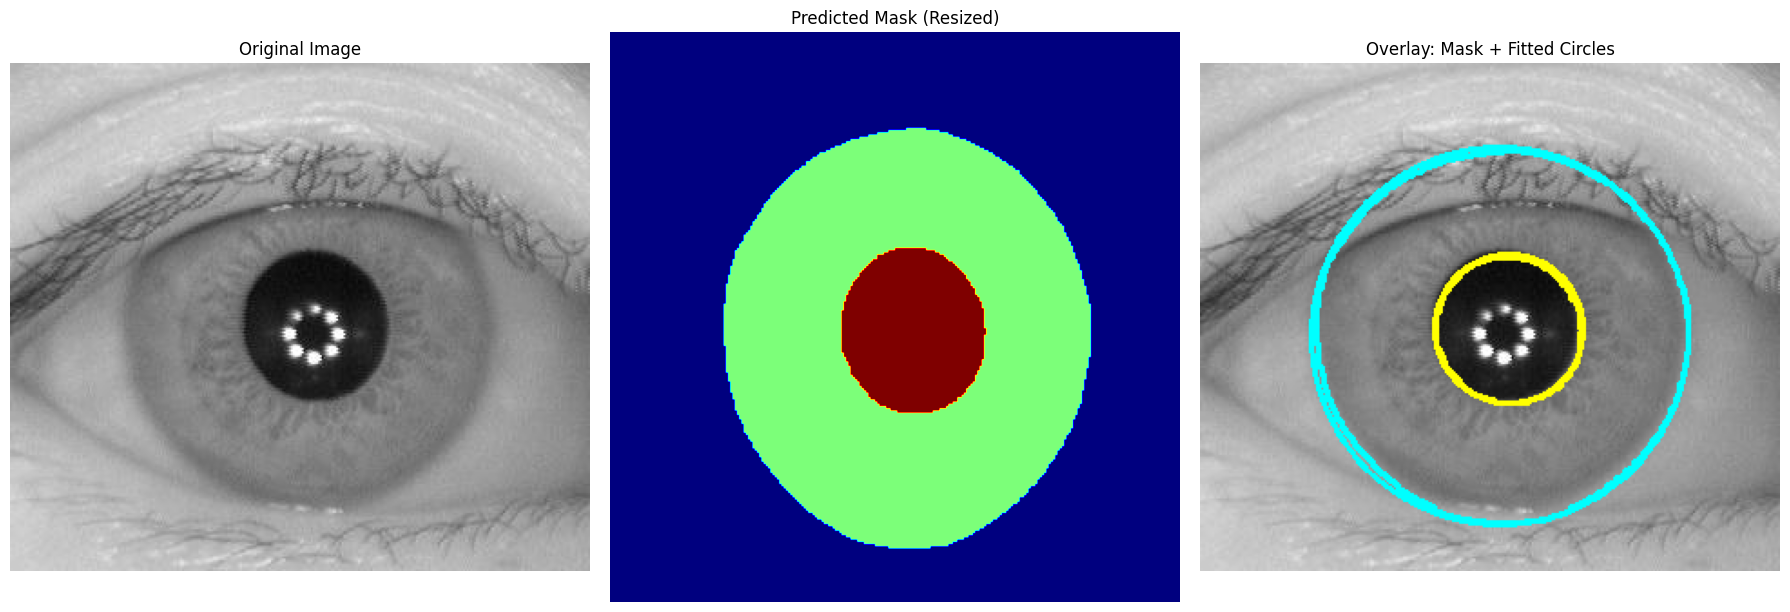

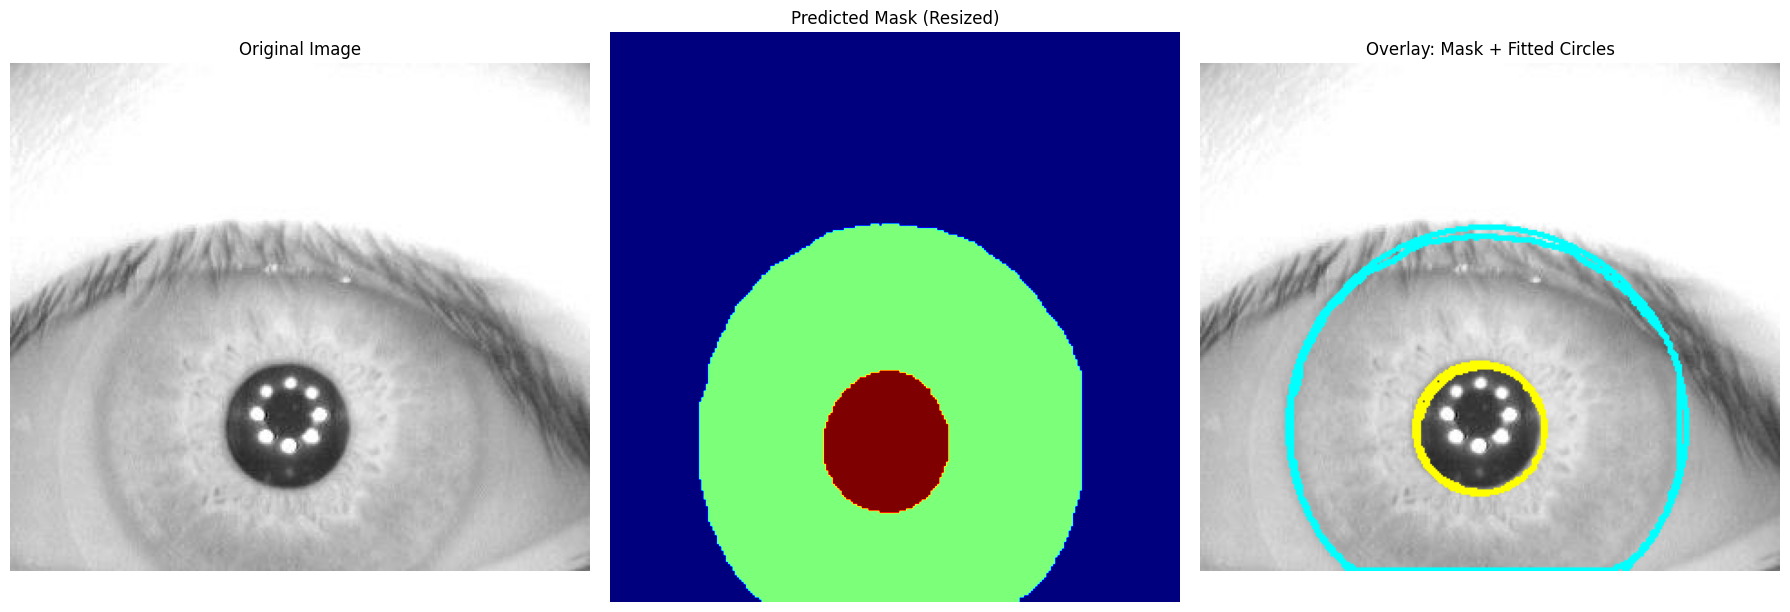

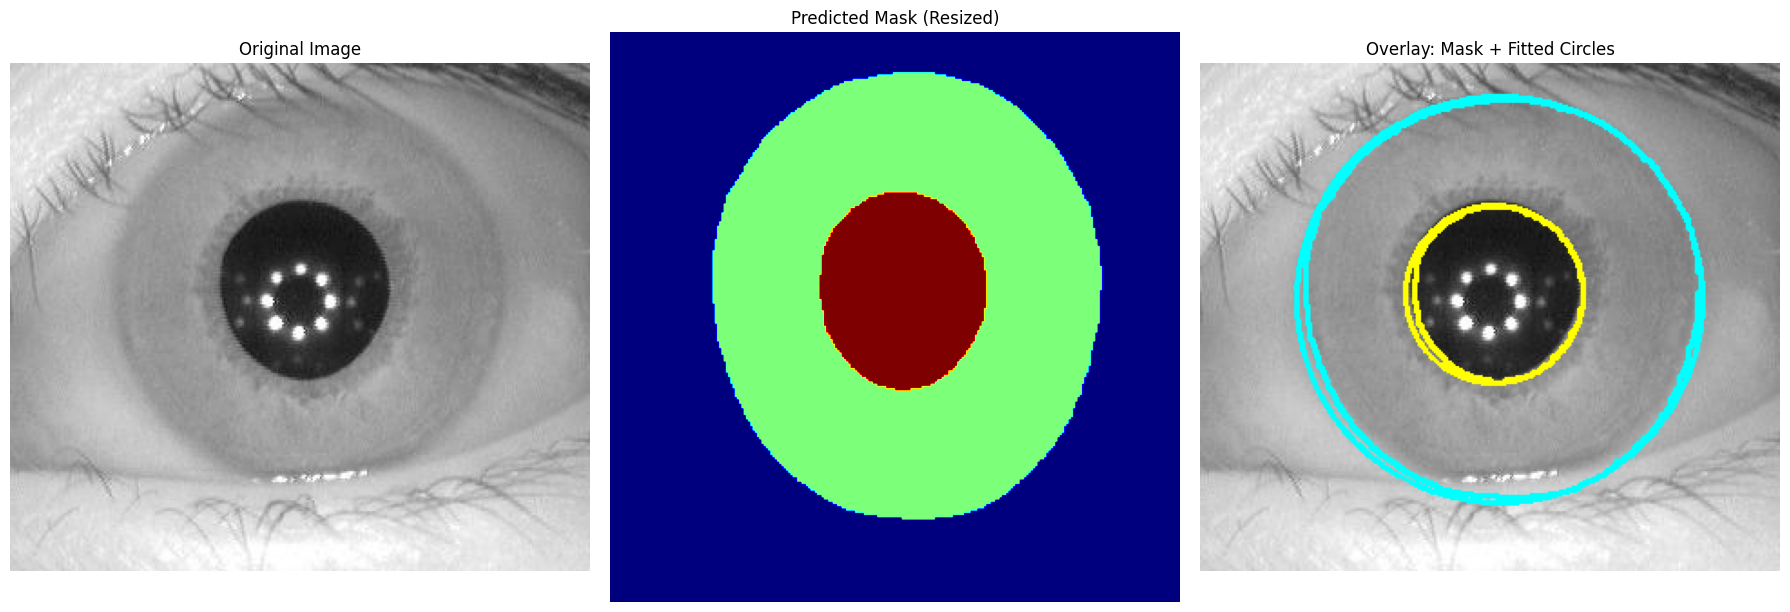

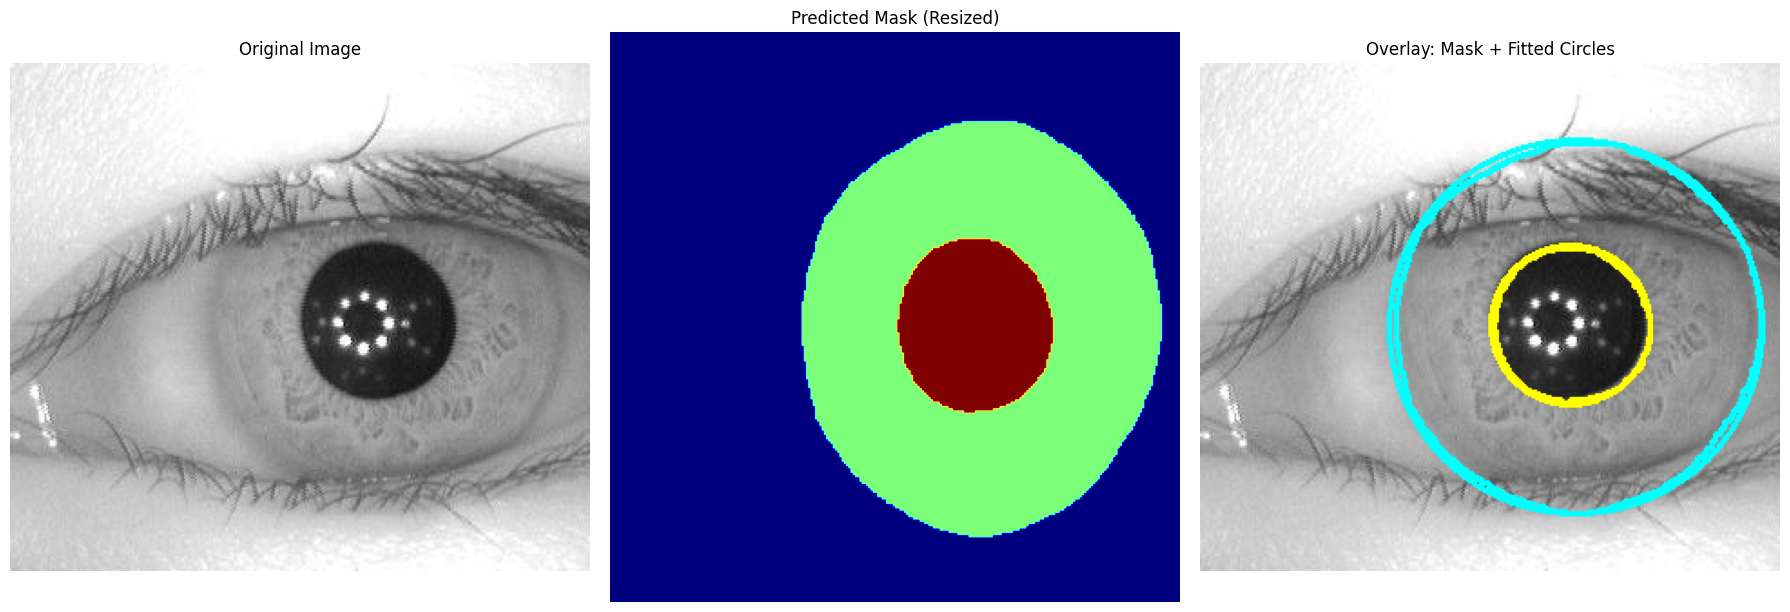

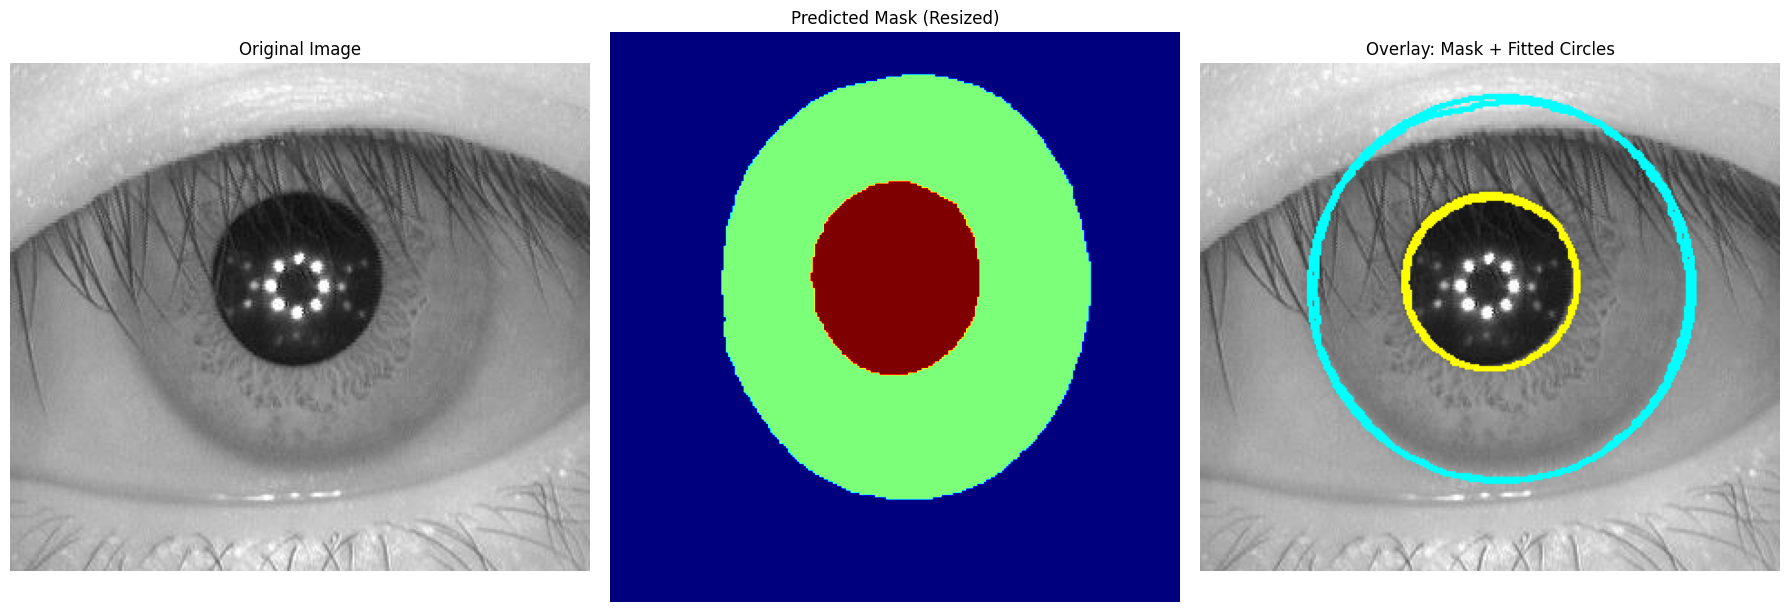

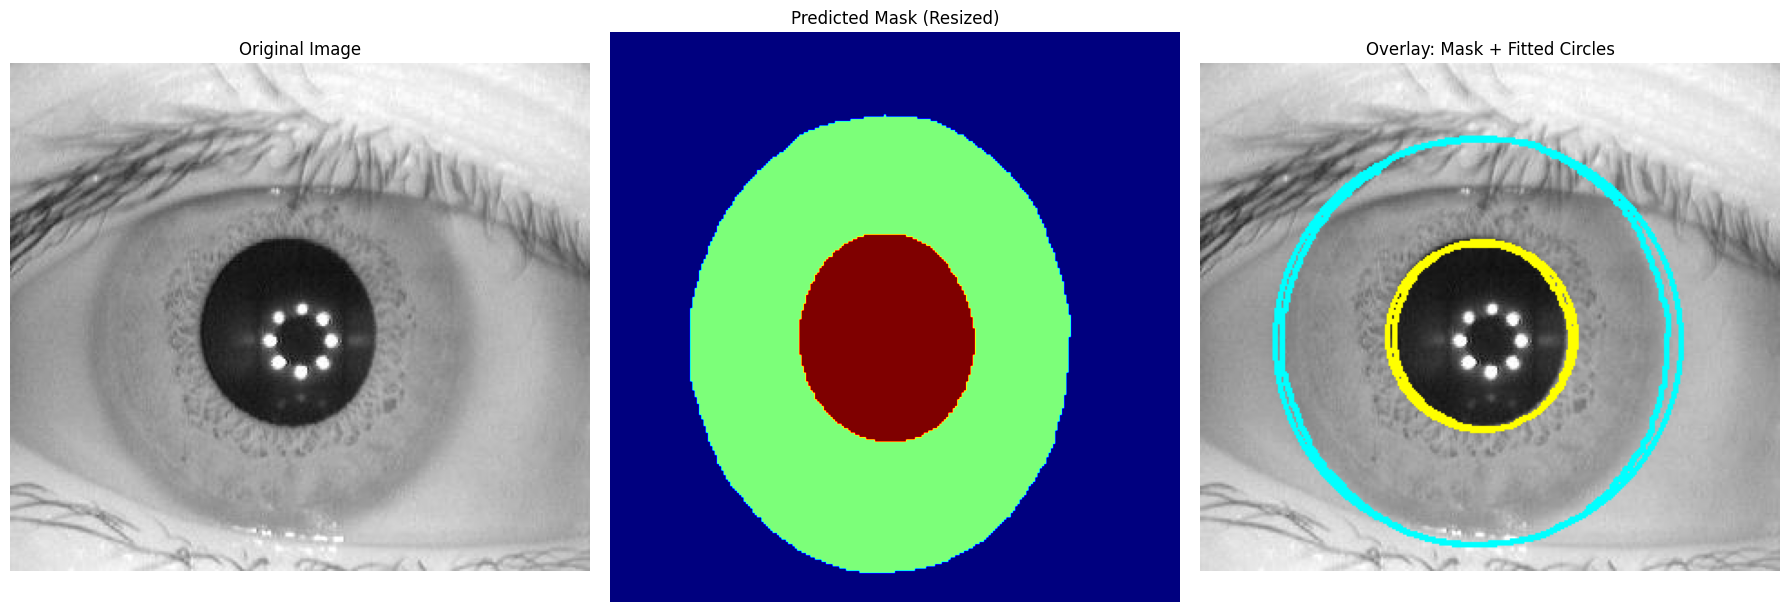

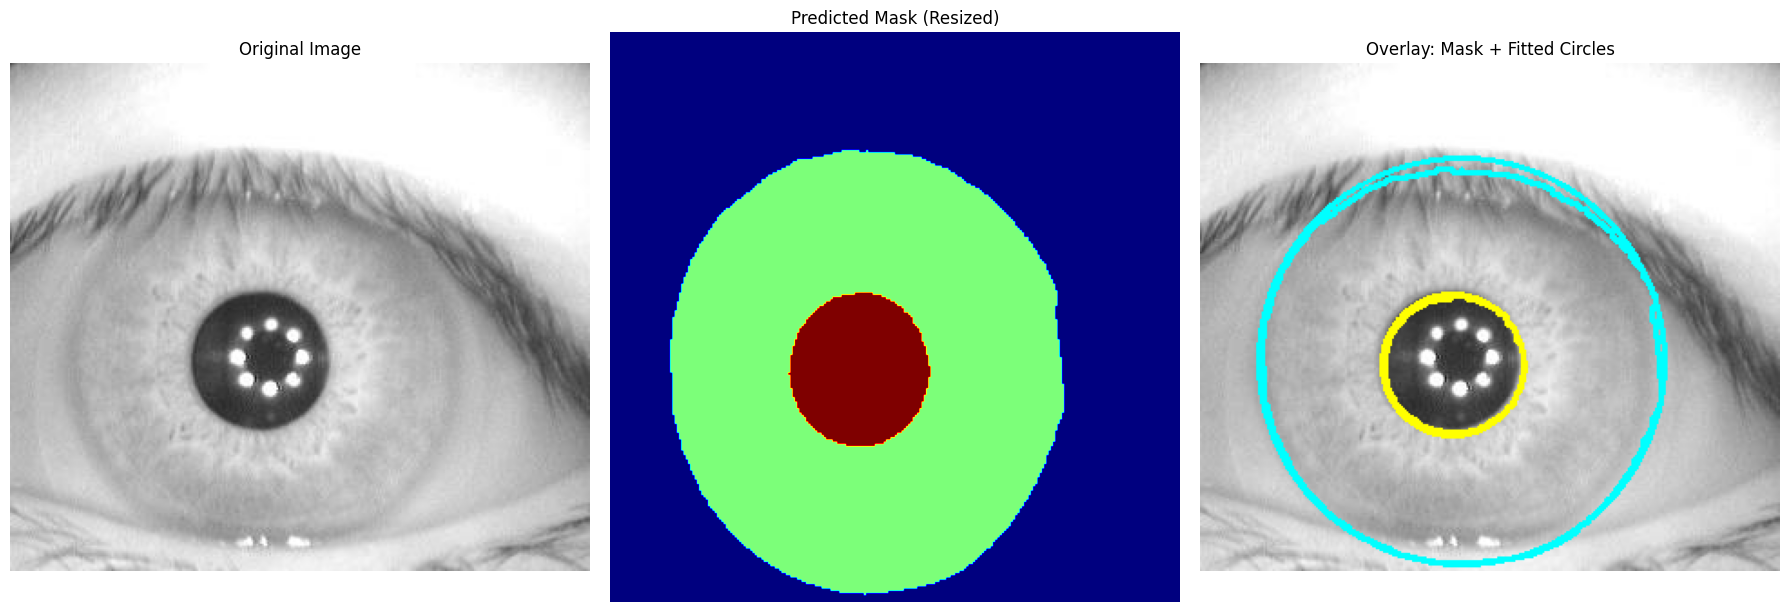

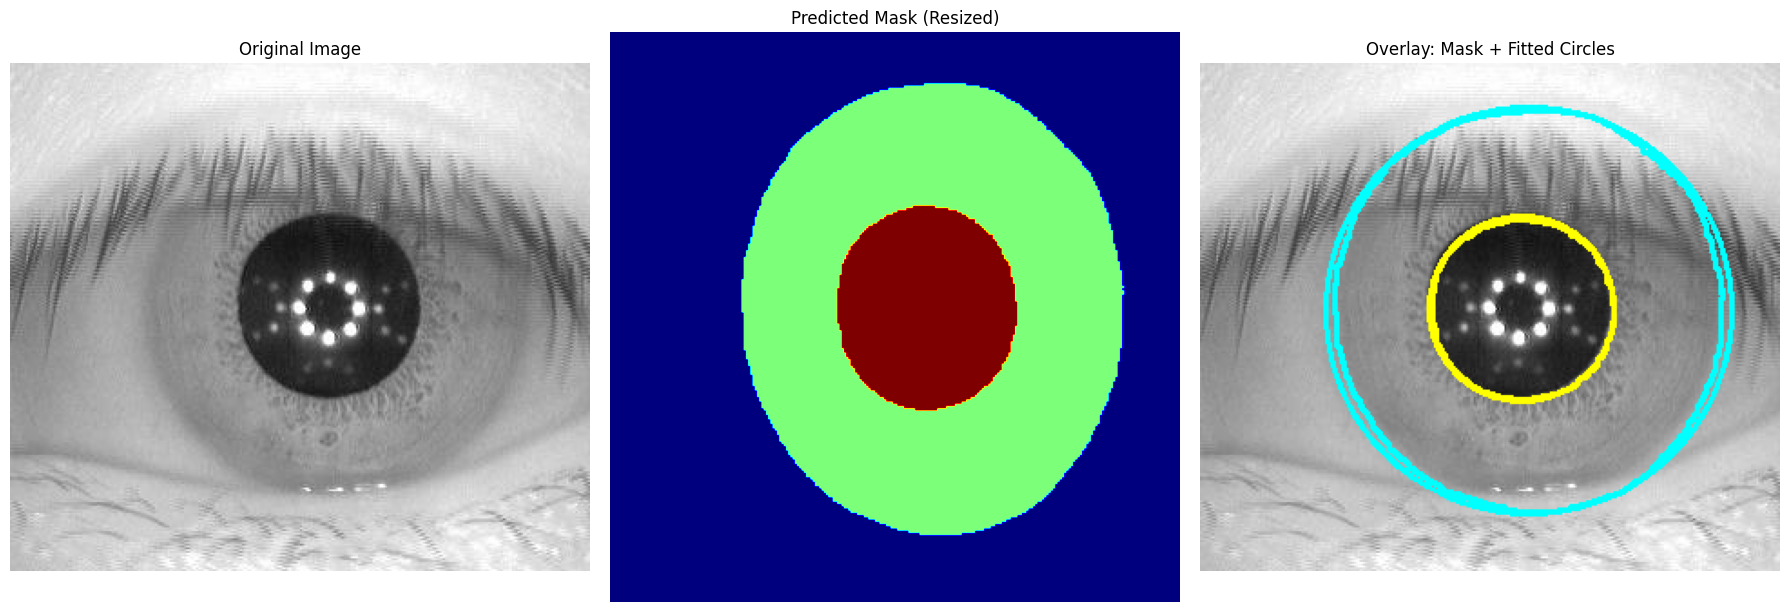

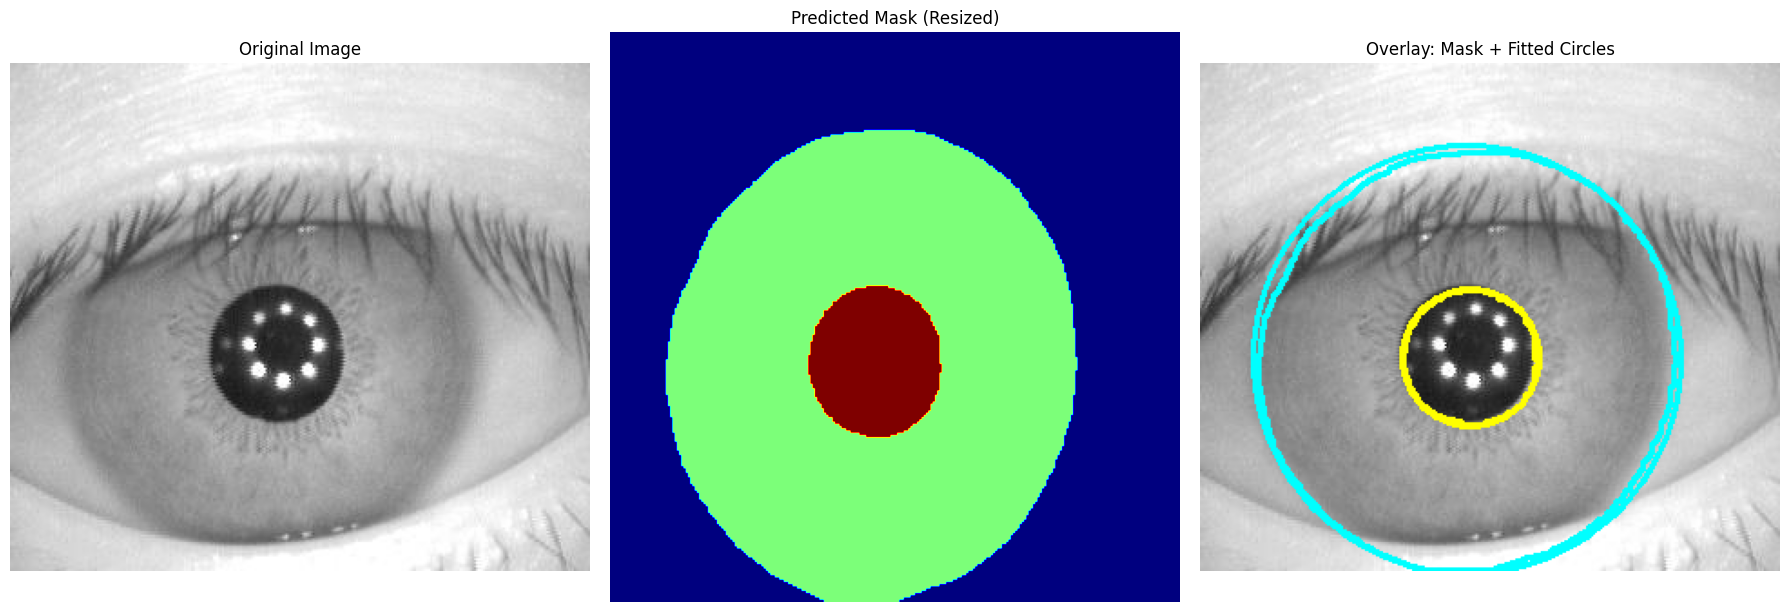

In [34]:
for i in range(13):
    visualize_prediction_with_circles(model, val_dataset, idx=i)




NameError: name 'iris_mask' is not defined